In [1]:
%load_ext autoreload
%autoreload 2

from utils import MLP, Trainer, set_seed, model_builder
from torchvision import datasets
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


seed = 42 # for reproducibility

## Regularization in Neural Networks

In this tutorial, we explore **regularization techniques** in the context of training a neural network using the MNIST dataset. Regularization is essential for controlling overfitting and improving generalization by applying constraints to the model. We will use **L2 regularization (weight decay)**, but you can also switch to **L1 regularization**. Additionally, we’ll explore **dropout** and **early stopping** as forms of regularization.

## Hyperparameters

We begin by setting important hyperparameters for the training:

- **Number of epochs** (`num_epochs`): Defines the total number of times the entire dataset is passed through the network during training. We've set this to 10, allowing the model to train long enough while preventing excessive overfitting.
- **Batch size** (`batch_size`): This specifies how many samples to process at once before updating the model’s weights. A batch size of 64 is commonly used for balanced performance.
- **K-fold cross-validation** (`k_folds`): We use 3 folds, which means the dataset will be split into 3 parts, training the model on two of them and validating on the third, ensuring better generalization by training and validating multiple times.
- **Hidden neurons** (`hidden_neurons`): The architecture of the model has 3 layers with 32, 32, and 16 neurons, respectively.
- **Regularization type** (`reg_type`): We specify L2 regularization, which penalizes large weights, thus forcing the model to prefer smaller weights, helping avoid overfitting.
- **Regularization strength** (`reg_lambda`): A value of 0.01 is used for the strength of regularization, which controls how much penalty is applied. You can increase or decrease this depending on the level of regularization you need.
- **Early stopping** (`early_stopping`): Early stopping is disabled for now, but it can be enabled to stop training if the validation performance stops improving after a few epochs, which is determined by the `patience` parameter. Early stopping itself acts as a form of regularization because it prevents the model from training too long and overfitting.
- **Dropout rate** (`dropout_rate`): Dropout is a regularization technique that randomly "drops" a percentage of neurons during training, preventing the network from over-relying on specific neurons. Here, we set it to 0, meaning no dropout is applied.

## Dataset and Transformation

The dataset used is the **MNIST** dataset, which consists of grayscale images of handwritten digits (0-9). We apply two common transformations:

1. **ToTensor**: Converts the images to PyTorch tensors and scales the pixel values to the range [0, 1].
2. **Normalization**: We normalize the images using the precomputed mean (`0.1307`) and standard deviation (`0.3081`). This is important for ensuring that the model receives consistent and normalized data, speeding up convergence during training.

## Regularization in Cross-Validation

We use **K-fold cross-validation** to train and evaluate our model across multiple splits of the data. This ensures that the model is evaluated on different subsets of the data, helping it generalize better.

L2 regularization, defined by the **weight decay** term, is applied in the optimizer. This helps prevent the model from becoming too complex by penalizing large weights. If we wanted to use **L1 regularization** (which encourages sparsity by penalizing the absolute value of weights), we could simply change `reg_type` to `'l1'`.

## Cross-Validation

The `Trainer` class is responsible for managing the training process, including applying regularization, performing cross-validation, and (if enabled) handling early stopping. Early stopping itself acts as a regularization technique because it helps prevent overfitting by halting training once the validation performance starts to deteriorate.

Here, the trainer handles everything from creating the model using the `model_builder` function, to applying the correct transformations, and executing the k-fold cross-validation procedure.

By the end of the cross-validation, we should have a model that benefits from both L2 regularization (controlling large weights) and the enhanced evaluation provided by cross-validation, making it more robust and less prone to overfitting.


### Loading the dataset

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


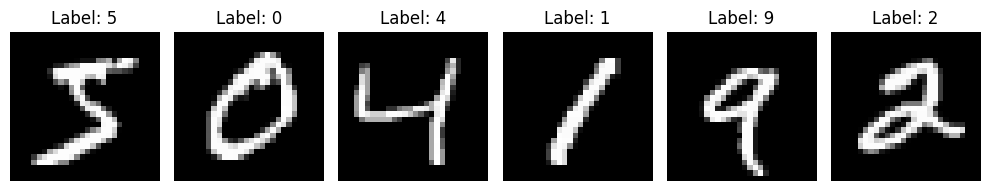

In [2]:
# Data loading and transformation
transform = transforms.Compose([
    transforms.ToTensor(), # transforms the input images to a pytorch tensor
                           # in the case of MNIST dataset, the original data is stores in uint8 format
                           # so it assumes values ranging from 0 to 255.
                           # the ToTensor transform also scales the data to the [0,1] range
    transforms.Normalize((0.1307,), (0.3081,)) # this removes the pre-caulculated mean (0.1307) and
                                               # divides by the standard deviation (0.3081)
                                               # to apply a z-score scaling
                           # Note: Generaly the correct way of dealing with scaling a dataset is to
                           # apply the normalization over each fold by (in the case of z-score scaling)
                           # estimating the mean and std deviation from training data and applying it to
                           # both training and validation
])

# Load the MNIST dataset
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Function to plot examples from the dataset
def plot_mnist_examples(dataset, num_examples=6):
    fig, axes = plt.subplots(1, num_examples, figsize=(10, 4))
    
    for i in range(num_examples):
        # Randomly sample an image from the dataset
        img, label = dataset[i]
        img = img.squeeze()  # Remove the color channel (1x28x28 -> 28x28)

        # Plot the image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot 6 random MNIST examples
plot_mnist_examples(dataset, num_examples=6)

In [ ]:
# Hyperparameters
num_epochs = 10  # Increased epochs to allow early stopping
batch_size = 64
k_folds = 3
hidden_neurons = (32, 32 ,16)
hidden_layers = len(hidden_neurons)
reg_type = 'l2'  # Options: 'l1', 'l2', or None
reg_lambda = 0.01  # Regularization strength (lambda)
early_stopping = False  # Enable early stopping
patience = 5  # Number of epochs to wait before stopping
dropout_rate = 0.0
    
criterion = nn.CrossEntropyLoss()

# Set seed for reproducibility
set_seed(seed)

# Initialize Trainer and start cross-validation with early stopping
trainer = Trainer(
    model_builder=model_builder(hidden_layers, 
                                hidden_neurons,
                                dropout_rate),
    dataset = dataset,
    criterion=criterion,
    num_epochs=num_epochs,
    batch_size=batch_size,
    k_folds=k_folds,
    reg_type=reg_type,
    reg_lambda=reg_lambda,
    early_stopping=early_stopping,
    patience=patience,
    seed=seed  # Set seed for reproducibility
)
trainer.cross_validate()

Fold 1/3
Fold 1, Epoch [1/10], Subtrain Loss: 2.3095, Internal Val Loss: 1.6559
Fold 1, Epoch [2/10], Subtrain Loss: 1.1975, Internal Val Loss: 0.9726
Fold 1, Epoch [3/10], Subtrain Loss: 0.8912, Internal Val Loss: 0.8385
Fold 1, Epoch [4/10], Subtrain Loss: 0.7998, Internal Val Loss: 0.7855
Fold 1, Epoch [5/10], Subtrain Loss: 0.7512, Internal Val Loss: 0.7422
Fold 1, Epoch [6/10], Subtrain Loss: 0.7186, Internal Val Loss: 0.7148
Fold 1, Epoch [7/10], Subtrain Loss: 0.6938, Internal Val Loss: 0.6976
Fold 1, Epoch [8/10], Subtrain Loss: 0.6735, Internal Val Loss: 0.6785
Fold 1, Epoch [9/10], Subtrain Loss: 0.6582, Internal Val Loss: 0.6655
Fold 1, Epoch [10/10], Subtrain Loss: 0.6445, Internal Val Loss: 0.6558
Fold 1, Final Validation Loss: 0.6463, Final Validation Accuracy: 92.20%
Fold 2/3
Fold 2, Epoch [1/10], Subtrain Loss: 2.4522, Internal Val Loss: 2.1475
Fold 2, Epoch [2/10], Subtrain Loss: 1.5659, Internal Val Loss: 1.1455
Fold 2, Epoch [3/10], Subtrain Loss: 0.9866, Internal Va

In [ ]:

# Create grid for the plots
fig = plt.figure(figsize=(14, 10))
gs = GridSpec(2, 2, figure=fig)

# Plot the loss (occupying two slots in the upper row)
ax_loss = fig.add_subplot(gs[0, :])
trainer.plot_loss(ax_loss)

# Plot t-SNE in the lower left slot
ax_tsne = fig.add_subplot(gs[1, 0])
trainer.apply_tsne(ax_tsne)

# Plot weights histogram in the lower right slot
ax_weights = fig.add_subplot(gs[1, 1])
ax_weights.set_yscale("log")
trainer.plot_weights_histogram(ax_weights)

plt.tight_layout()
plt.show()


## Extra: Orthogonal Matching Pursuit

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import DictionaryLearning

# Step 1: Load MNIST dataset
print("Loading MNIST data...")
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0  # Normalize to [0, 1]
y = mnist.target.astype(int)

X = X[::70]
y = y[::70]

# Use a subset of the MNIST data to speed up the computation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Step 2: Create a Dictionary using DictionaryLearning
# We'll use DictionaryLearning to learn a set of dictionary atoms from the MNIST dataset.
print("Learning the dictionary...")
n_atoms = 100  # Number of dictionary atoms
dict_learning = DictionaryLearning(n_components=n_atoms, transform_algorithm='omp', random_state=42, max_iter=100)
dictionary = dict_learning.fit(X_train).components_

# Step 3: Apply Orthogonal Matching Pursuit (OMP) for sparse coding
# We'll apply OMP to sparsely represent test MNIST images using the learned dictionary.
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)

# We will now sparsely code and reconstruct some test images.
n_samples_to_reconstruct = 5
reconstructed_images = []

print("Reconstructing test images using OMP...")
for i in range(n_samples_to_reconstruct):
    test_image = X_test.iloc[i].to_numpy().reshape(1, -1)  # Flatten the test image

    # Fit OMP on the test image using the learned dictionary
    omp.fit(dictionary.T, test_image.T)

    # Get sparse coefficients
    sparse_code = omp.coef_

    # Reconstruct the image using the sparse code and dictionary
    reconstructed_image = np.dot(sparse_code, dictionary)

    # Store the reconstructed image
    reconstructed_images.append(reconstructed_image)

# Step 4: Plot the original and reconstructed images
fig, axes = plt.subplots(2, n_samples_to_reconstruct, figsize=(15, 5))

for i in range(n_samples_to_reconstruct):
    # Plot original image
    axes[0, i].imshow(X_test.iloc[i].to_numpy().reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"Original Image {i+1}")
    axes[0, i].axis('off')

    # Plot reconstructed image
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f"Reconstructed Image {i+1}")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
X.shape